# Persiapan

In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import DoubleType
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Initialize Spark session
spark = SparkSession.builder.appName("Heart Disease Analysis").getOrCreate()

# Load the dataset
file_path = "/content/drive/MyDrive/heart_statlog_cleveland_hungary_final.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Preprocessing data
# 1. Check for null values
null_values = data.select([(count(col(c)) == 0).alias(c) for c in data.columns]).collect()[0]
print("\nNull Values in Dataset :")
for col_name, is_null in zip(data.columns, null_values):
    print(f"{col_name}: {'No Nulls' if is_null else 'Has Nulls'}")


Null Values in Dataset :
age: Has Nulls
sex: Has Nulls
chest pain type: Has Nulls
resting bp s: Has Nulls
cholesterol: Has Nulls
fasting blood sugar: Has Nulls
resting ecg: Has Nulls
max heart rate: Has Nulls
exercise angina: Has Nulls
oldpeak: Has Nulls
ST slope: Has Nulls
target: Has Nulls


In [ ]:
# Rename columns for easier analysis
data = data.selectExpr(
    "age as Age",
    "sex as Sex",
    "`chest pain type` as `Chest Pain Type`",
    "`resting bp s` as `Resting BP Systolic`",
    "cholesterol as Cholesterol",
    "`fasting blood sugar` as `Fasting Blood Sugar`",
    "`resting ecg` as `Resting ECG`",
    "`max heart rate` as `Max Heart Rate`",
    "`exercise angina` as `Exercise Angina`",
    "oldpeak as Oldpeak",
    "`ST slope` as `ST Slope`",
    "target as Target"
)
print("\nRenamed Columns:")
print(", ".join(data.columns))


Renamed Columns:
Age, Sex, Chest Pain Type, Resting BP Systolic, Cholesterol, Fasting Blood Sugar, Resting ECG, Max Heart Rate, Exercise Angina, Oldpeak, ST Slope, Target


# EDA

In [ ]:
data.show()

+---+---+---------------+-------------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+------+
|Age|Sex|Chest Pain Type|Resting BP Systolic|Cholesterol|Fasting Blood Sugar|Resting ECG|Max Heart Rate|Exercise Angina|Oldpeak|ST Slope|Target|
+---+---+---------------+-------------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+------+
| 40|  1|              2|                140|        289|                  0|          0|           172|              0|    0.0|       1|     0|
| 49|  0|              3|                160|        180|                  0|          0|           156|              0|    1.0|       2|     1|
| 37|  1|              2|                130|        283|                  0|          1|            98|              0|    0.0|       1|     0|
| 48|  0|              4|                138|        214|                  0|          0|           108|              1|    1.5|  

In [ ]:
# 3. Data types of the columns
data_types = {col_name: dtype for col_name, dtype in data.dtypes}
print("\nData Types : ")
for col_name, dtype in data_types.items():
    print(f"{col_name}: {dtype}")


Data Types : 
Age: int
Sex: int
Chest Pain Type: int
Resting BP Systolic: int
Cholesterol: int
Fasting Blood Sugar: int
Resting ECG: int
Max Heart Rate: int
Exercise Angina: int
Oldpeak: double
ST Slope: int
Target: int


In [ ]:
# Convert to Pandas for EDA
pandas_data = data.toPandas()

# Exploratory Data Analysis (EDA)
sns.set(style="whitegrid", palette="muted")

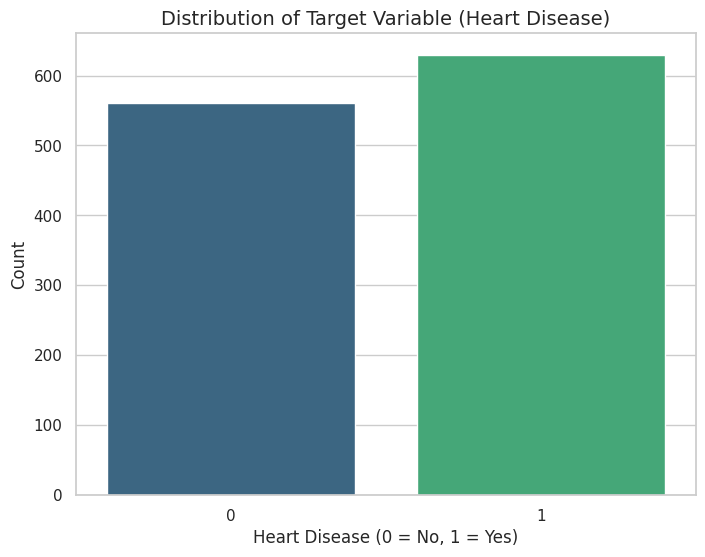

In [ ]:
# Visualizing distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=pandas_data, x="Target", hue="Target", palette="viridis", dodge=False)
plt.title("Distribution of Target Variable (Heart Disease)", fontsize=14)
plt.xlabel("Heart Disease (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend([],[], frameon=False)
plt.show()

<ipython-input-74-1e474db5fb6a>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette="viridis")


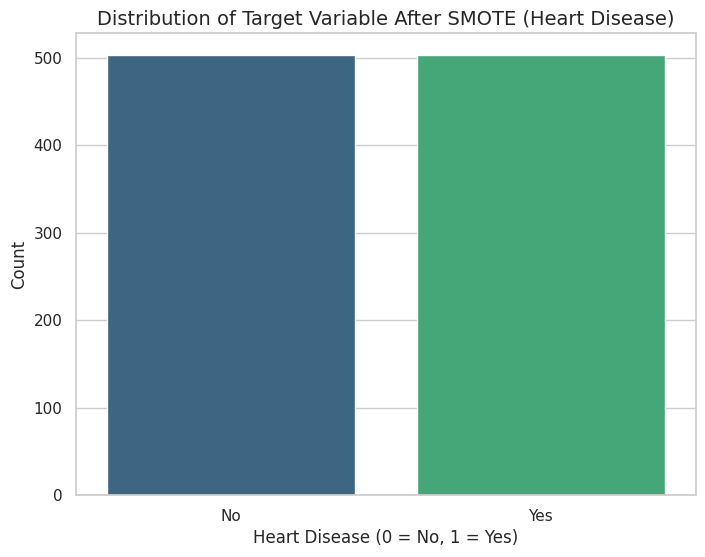

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming pandas_data is your DataFrame and 'Target' is your target variable
# Separate features and target variable
X = pandas_data.drop('Target', axis=1)  # Features
y = pandas_data['Target']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Visualizing the distribution of the target variable after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, palette="viridis")
plt.title("Distribution of Target Variable After SMOTE (Heart Disease)", fontsize=14)
plt.xlabel("Heart Disease (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

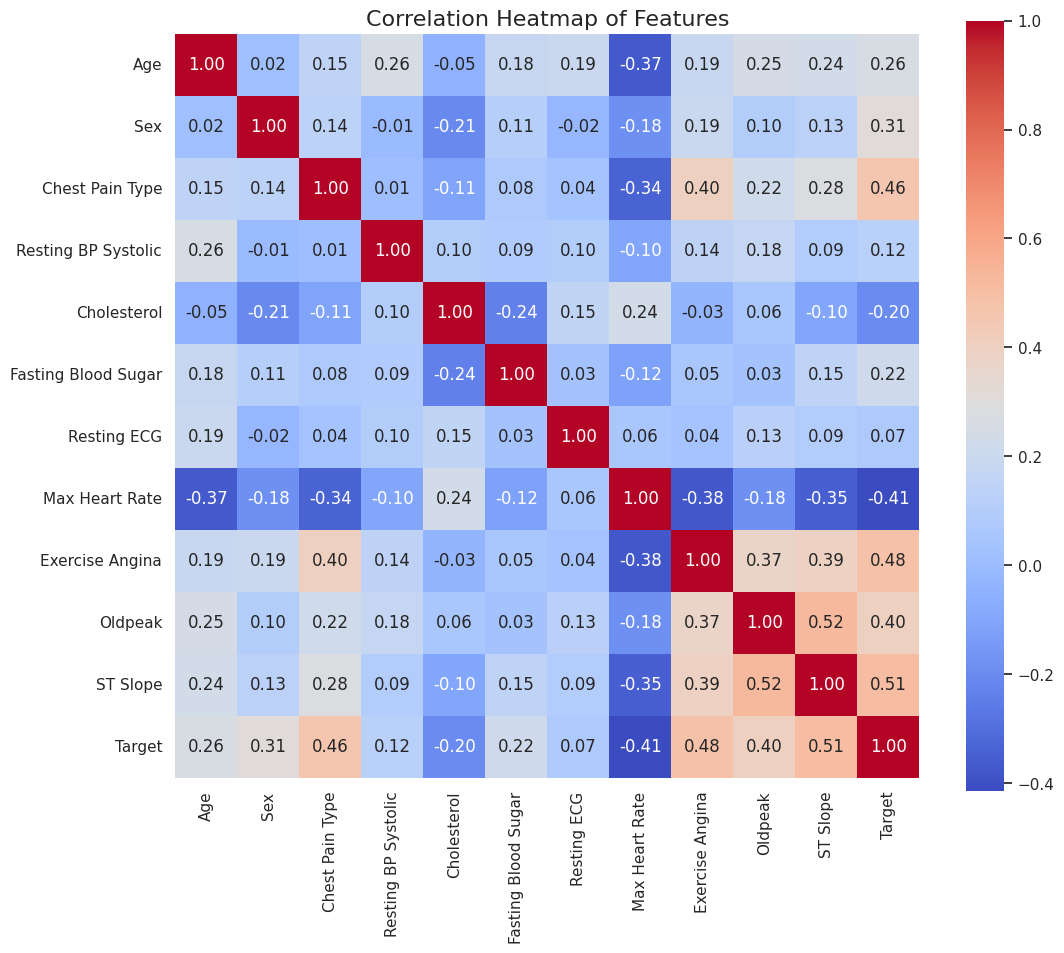

In [ ]:
# Visualizing the correlation heatmap
plt.figure(figsize=(12, 10))
correlation = pandas_data.corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()

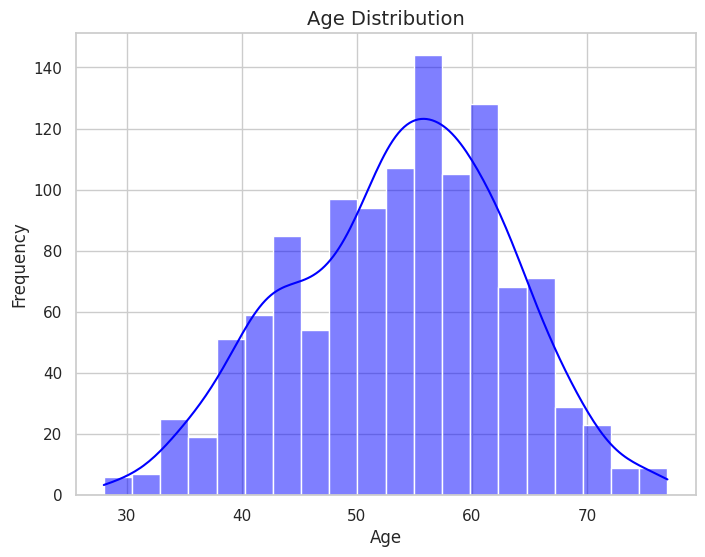

In [ ]:
# Visualizing Age distribution
plt.figure(figsize=(8, 6))
sns.histplot(pandas_data["Age"], bins=20, kde=True, color="blue")
plt.title("Age Distribution", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

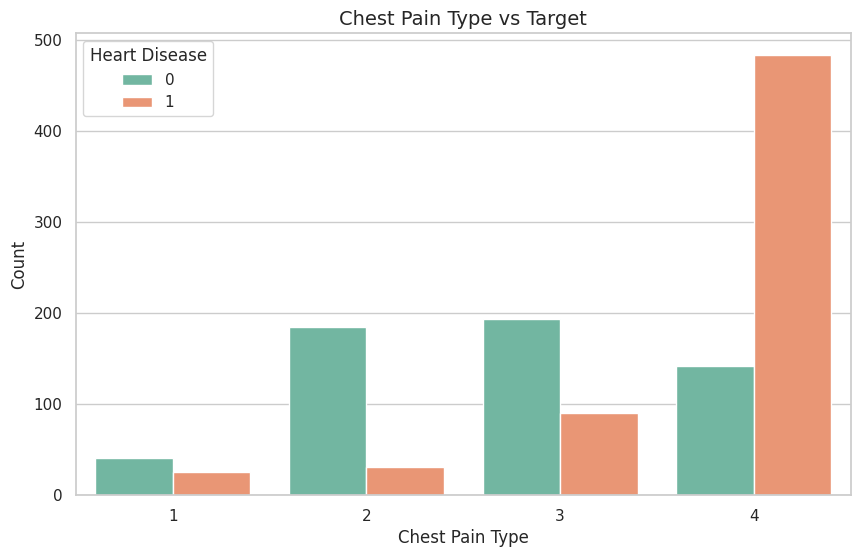

In [ ]:
# Visualizing Chest Pain Type vs Target
plt.figure(figsize=(10, 6))
sns.countplot(x="Chest Pain Type", hue="Target", data=pandas_data, palette="Set2")
plt.title("Chest Pain Type vs Target", fontsize=14)
plt.xlabel("Chest Pain Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Heart Disease")
plt.show()

# KLASIFIKASI

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# Assemble features
feature_columns = [
    "Age", "Sex", "Chest Pain Type", "Resting BP Systolic", "Cholesterol",
    "Fasting Blood Sugar", "Resting ECG", "Max Heart Rate", "Exercise Angina",
    "Oldpeak", "ST Slope"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data).select("features", "Target")

In [ ]:
X = data.select("features").toPandas()["features"].tolist()
y = data.select("Target").toPandas()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Inisialisasi Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih model
rf.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = rf.predict(X_test)

# Laporan klasifikasi
report = classification_report(y_test, y_pred, digits=2)
print("Classification Report:")
print(report)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       107
           1       0.93      0.97      0.95       131

    accuracy                           0.95       238
   macro avg       0.95      0.94      0.94       238
weighted avg       0.95      0.95      0.95       238



In [ ]:
# Inisialisasi Gradient Boosted Tree
gbt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Melatih model
gbt.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = gbt.predict(X_test)

# Laporan klasifikasi
report = classification_report(y_test, y_pred, digits=2)
print("Classification Report:")
print(report)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       107
           1       0.92      0.93      0.92       131

    accuracy                           0.92       238
   macro avg       0.92      0.91      0.91       238
weighted avg       0.92      0.92      0.92       238



In [ ]:
# Inisialisasi Decision Tree
dt = DecisionTreeClassifier(max_depth=5, random_state=42)

# Melatih model
dt.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = dt.predict(X_test)

# Laporan klasifikasi
report = classification_report(y_test, y_pred, digits=2)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       107
           1       0.82      0.93      0.87       131

    accuracy                           0.85       238
   macro avg       0.86      0.84      0.84       238
weighted avg       0.85      0.85      0.85       238



In [ ]:
# Inisialisasi SVM
svm_model = SVC(kernel='linear', random_state=42)

# Melatih model
svm_model.fit(X_train, y_train)

# Prediksi pada data uji
y_pred = svm_model.predict(X_test)

# Laporan klasifikasi
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       107
           1       0.86      0.87      0.86       131

    accuracy                           0.85       238
   macro avg       0.85      0.85      0.85       238
weighted avg       0.85      0.85      0.85       238



Berdasarkan data yang diberikan, 2 model dengan performa terbaik adalah:
* **Random Forest**
* **Gradient Boost Tree**

# Hypertuning



*   Random Forest



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Tentukan parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt']
}

# Inisialisasi model Random Forest
rf = RandomForestClassifier(random_state=42)

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=0);

# Latih model
grid_search.fit(X_train, y_train)

# Dapatkan model terbaik
best_rf = grid_search.best_estimator_

# Evaluasi model terbaik
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       107
           1       0.92      0.93      0.92       131

    accuracy                           0.92       238
   macro avg       0.92      0.91      0.91       238
weighted avg       0.92      0.92      0.92       238



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Tentukan parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt']
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Melatih model dengan GridSearchCV
grid_search.fit(X_train, y_train)

# Dapatkan model terbaik
best_rf = grid_search.best_estimator_

# Prediksi pada data uji
y_pred = best_rf.predict(X_test)

# Evaluasi model
report = classification_report(y_test, y_pred, digits=2)
print("Classification Report:")
print(report)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       107
           1       0.95      0.97      0.96       131

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238





*   Gradient Boost Tree



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier  # Import GBT

# Tentukan parameter grid untuk GBT
param_grid_gbt = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Inisialisasi model GBT
gbt = GradientBoostingClassifier(random_state=42)

# Inisialisasi GridSearchCV
grid_search_gbt = GridSearchCV(estimator=gbt, param_grid=param_grid_gbt, cv=5, scoring='accuracy', verbose=0)

# Latih model
grid_search_gbt.fit(X_train, y_train.values.ravel())

# Dapatkan model terbaik
best_gbt = grid_search_gbt.best_estimator_

# Evaluasi model terbaik (contoh menggunakan classification_report)
y_pred_gbt = best_gbt.predict(X_test)
report_gbt = classification_report(y_test, y_pred_gbt, digits=2)
print("Classification Report (GBT):")
print(report_gbt)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1215 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1215 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/u

Classification Report (GBT):
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       107
           1       0.94      0.95      0.94       131

    accuracy                           0.94       238
   macro avg       0.94      0.94      0.94       238
weighted avg       0.94      0.94      0.94       238



Setelah melakukan Hypertuning, model dengan performa terbaik adalah:
* **Gradient Boost Tree**